## Restart

In [3]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)
baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})

baseball = baseball.dropna()

In [23]:
baseball['description'].value_counts()

0    85972
1    40526
Name: description, dtype: int64

In [24]:

ball_df = baseball.loc[baseball['description'] == 0]
strike_df = baseball.loc[baseball['description'] == 1]

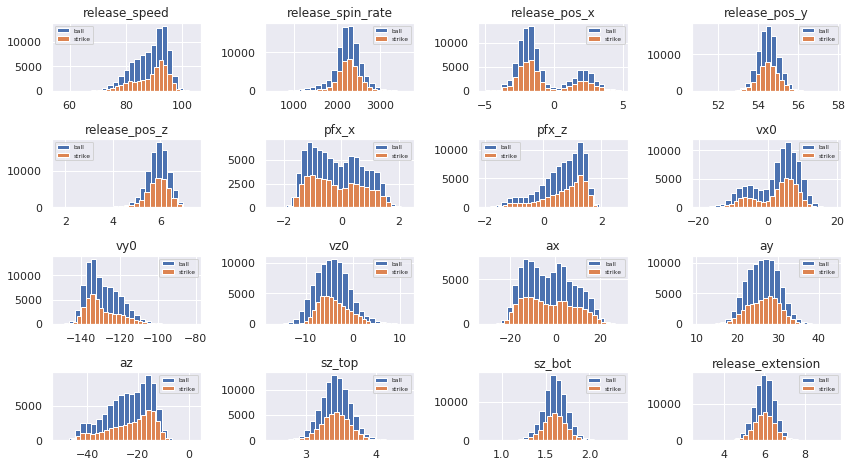

In [25]:
num_features_to_plot = ['release_speed', 'release_spin_rate', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_extension']

fig = plt.figure(figsize = (12, 8))
for idx, feature in enumerate(num_features_to_plot):
    idx+=1
    plt.subplot(5,4, idx, title = feature )
    plt.hist(ball_df[feature], bins = 25, label='ball')
    plt.hist(strike_df[feature], bins = 25, label = 'strike')
    plt.legend(fontsize = 6)
    idx +=1
    plt.tight_layout()
    

### Cross tab


In [26]:
pd.crosstab(baseball['description'], baseball['pitch_name'] ,normalize=True).T

description,0,1
pitch_name,,
2-Seam Fastball,0.073456,0.039242
4-Seam Fastball,0.228755,0.123267
Changeup,0.072033,0.018846
Curveball,0.060649,0.028388
Cutter,0.041186,0.017747
Eephus,0.000079,0.000016
Knuckle Curve,0.017060,0.008221
Sinker,0.063052,0.037234
Slider,0.110674,0.044941


## Feature Creation
1. posx + movementx, posz +movementz
2. topzone - bottom zone
3. compare to target

In [5]:
baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']

baseball['height_of_zone'] = baseball['sz_top'] - baseball['sz_bot']

baseball['area_of_zone'] = 17 * baseball['height_of_zone']

In [28]:
ball_df = baseball.loc[baseball['description'] == 0]
strike_df = baseball.loc[baseball['description'] == 1]

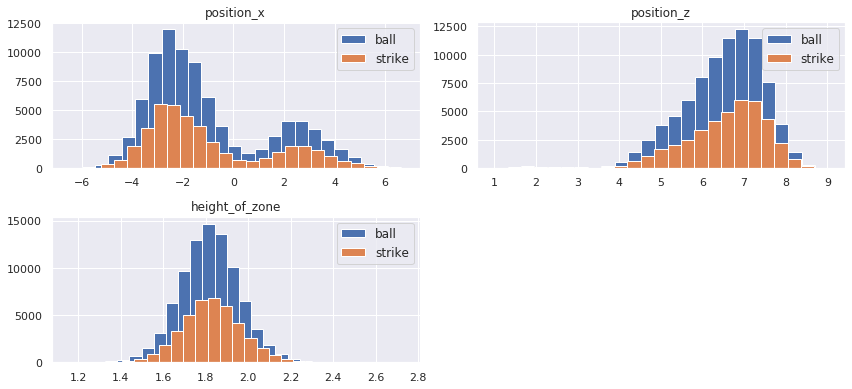

In [29]:
fig = plt.figure(figsize = (12, 8))
for idx, feature in enumerate(['position_x',
'position_z', 'height_of_zone']):
    idx+=1
    plt.subplot(3,2, idx, title = feature )
    plt.hist(ball_df[feature], bins = 25, label='ball')
    plt.hist(strike_df[feature], bins = 25, label = 'strike')
    plt.legend(fontsize = 12)
    idx +=1
    plt.tight_layout()
    

In [ ]:
sns.relplot('sz_top', 'sz_bot', data = baseball, markers= = 'position_z',hue = 'description')

## Downsample

use downsampling to see if results from above hold true. Will even out the classes.


In [59]:
target = 'description'
predictors = [col for col in baseball.columns if col not in [target]]


under_sampled = RandomUnderSampler(ratio = 1, random_state = 777).fit_resample(baseball[predictors], baseball[target])
baseball_down = pd.DataFrame(under_sampled[0], columns = baseball[predictors].columns)
baseball_down['description'] = under_sampled[1]

In [78]:
baseball_down['description'].value_counts()

1    40526
0    40526
Name: description, dtype: int64

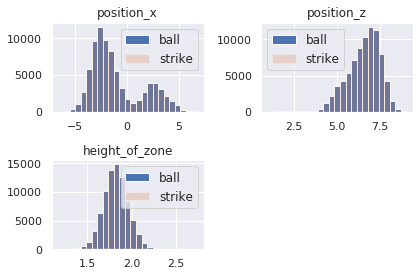

In [82]:
for idx, col in enumerate(['position_x', 'position_z', 'height_of_zone']):
    idx+=1
    plt.subplot(2,2, idx, title = col )
    plt.hist(baseball_down[col], bins = 25, label='ball')
    plt.hist(baseball_down[col], bins = 25, label = 'strike', alpha = .25)
    plt.legend(fontsize = 12)
    idx +=1
    plt.tight_layout()

In [84]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description', 'position_x',
       'position_z', 'height_of_zone', 'area_of_zone'],
      dtype='object')

In [6]:
final_df = baseball.loc[:, ['position_x', 'position_z', 'height_of_zone', 'pitch_name', 'release_speed', 
                           'release_spin_rate', 'vx0', 'vy0', 'vz0', 'release_pos_y', 'description']]

final_df=pd.get_dummies(final_df, prefix = 'pitch')
final_df.head()

,position_x,position_z,height_of_zone,release_speed,release_spin_rate,vx0,vy0,vz0,release_pos_y,description,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Eephus,pitch_Knuckle Curve,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,4.9868,5.6846,1.7912,95.1,2314.0,-9.8035,-138.1130,0.1339,54.4995,0,1,0,0,0,0,0,0,0,0,0
1,4.1077,6.3981,1.7406,96.7,2324.0,-9.0084,-140.5865,-2.4218,54.3094,1,0,1,0,0,0,0,0,0,0,0
2,2.3349,4.9982,2.2039,80.8,2521.0,-3.7285,-117.3223,1.2140,55.0820,1,0,0,0,0,0,0,0,0,1,0
3,4.4509,6.1538,1.9914,96.2,2329.0,-12.0533,-139.3669,-5.1407,54.0207,1,0,1,0,0,0,0,0,0,0,0
4,4.5827,5.8014,1.7209,96.5,2437.0,-14.0287,-139.8559,-3.3434,54.3597,0,0,1,0,0,0,0,0,0,0,0


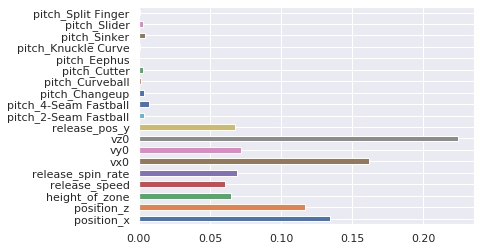

In [53]:
forest.fit(X_train, y_train)

pred = forest.predict(X_test)

pd.Series(forest.feature_importances_, index=X_train.columns).plot(kind = 'barh')

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split

## USE PCA

In [9]:

X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns='description'),
                                                    final_df['description'], random_state = 777)

for n_components in [2,4,6,8]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    forest = RandomForestClassifier(n_estimators=10)
    
    pipe = Pipeline(steps = [
        ('pca', pca),
        ('forest', forest)
    ])
    
    cv_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =3, return_estimator=True, return_train_score = True)

    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(cv_results[result])}")
        print(f"{result} scores: {cv_results[result]}")
        print() 
    

    


Number of Components: 2
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.9670296071949647
train_accuracy scores: [0.96687642 0.96714573 0.96706667]

Mean test_accuracy Value: 0.6236969397002393
test_accuracy scores: [0.62393676 0.62218568 0.62496838]

Mean train_f1 Value: 0.9462146066383514
train_f1 scores: [0.94598984 0.94639356 0.94626042]

Mean test_f1 Value: 0.23710775740123116
test_f1 scores: [0.23943212 0.23518115 0.23671   ]

Mean train_roc_auc Value: 0.9976559312544101
train_roc_auc scores: [0.99749297 0.99768553 0.9977893 ]

Mean test_roc_auc Value: 0.517519467528614
test_roc_auc scores: [0.52129242 0.51437781 0.51688817]

Number of Components: 4
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.9809218661031416
train_accuracy scores: [0.98132747 0.98126453 0.9801736 ]

Mean test_accuracy Value: 0.7011373116996914
test_accuracy scores: [0.70096443 0.69934227 0.70310

In [46]:
cv_results['estimator'][0][1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
predictions = cv_results['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

Accuracy Score: 0.8888537549407115

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     21552
           1       0.87      0.77      0.82     10073

    accuracy                           0.89     31625
   macro avg       0.88      0.86      0.87     31625
weighted avg       0.89      0.89      0.89     31625


 Confustion Matrix: 
 [[20362  1190]
 [ 2325  7748]]


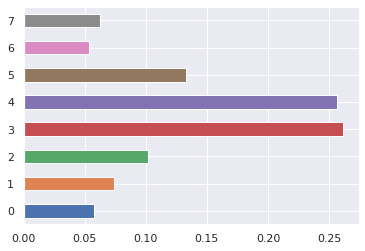

In [49]:
pd.Series(cv_results['estimator'][0][1].feature_importances_).plot(kind = 'barh')